In [ ]:
 # !curl -s https://course.fast.ai/setup/colab | bash
 !pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-fwhts97j
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-fwhts97j
     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for fastai: filename=fastai-2.2.4-cp36-none-any.whl size=190370 sha256=7240be6004745b147f394854ef2c2162774fbf2541e33719fd47adfe05227517
  Stored in directory: /tmp/pip-ephem-wheel-cache-15py9xuf/wheels/cf/46/39/b2d08762125ed2376861976ab2c4ac30c029b86e375735d9b8
Successfully built fastai
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.text.all import * 
import pandas as pd
from pathlib import Path
import json
import pandas as pd
 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file='/content/drive/My Drive/Sarcasm_Headlines_Dataset_v2.json'

 
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data(file))
sentences = []
labels = []
for item in data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
 
df=pd.DataFrame()
df['text']=sentences
df['labels']=labels
df['labels'].value_counts()




Use the below cell for proving any additional unsupervised in-domain data that you would like to use for LM finetuning

In [ ]:
data2 = list(parse_data(file2))
sentences2 = []
labels2 = []
for item in data2:
    sentences2.append(item['response'])
    labels2.append(0)
df2=pd.DataFrame()
df2['text']=sentences2
df2['labels']=labels2

In [ ]:
df_lm = pd.concat([df, df2], axis=0)[['text']]
df_lm

,text
0,thirtysomething scientists unveil doomsday clock of hair loss
1,"dem rep. totally nails why congress is falling short on gender, racial equality"
2,eat your veggies: 9 deliciously different recipes
3,inclement weather prevents liar from getting to work
4,mother comes pretty close to using word 'streaming' correctly
...,...
4395,well you could've been adulting if you hadn't waste your time so there's really nothing to complain about
4396,Also they'll have to join the euro
4397,plot: AI assists a cyborg in freelance investigation only to be caught up in politics as he is swept up in PH 2077 Tokhang Incidents
4398,Some airlines proposed this but too much public backlash.


In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, test_size=0.2)


In [ ]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(0, is_lm=True),
    get_x=ColReader(0), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

In [ ]:
dls_lm = dls_lm.dataloaders(df_lm, bs=64, seq_len=72)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos women 's health and xxunk in the u.s . xxbos who is hacking all of these ' glee ' stars ? xxbos pregnant kelly xxunk glows in form - xxunk gown xxbos what 's driving the recent xxunk in kabul xxbos ben carson xxunk by periodic rational thoughts xxbos government squandering social security funds on cake xxbos aol acquires time - warner in largest - ever xxunk of pretend internet money,women 's health and xxunk in the u.s . xxbos who is hacking all of these ' glee ' stars ? xxbos pregnant kelly xxunk glows in form - xxunk gown xxbos what 's driving the recent xxunk in kabul xxbos ben carson xxunk by periodic rational thoughts xxbos government squandering social security funds on cake xxbos aol acquires time - warner in largest - ever xxunk of pretend internet money xxbos
1,going to be xxbos new law requires welfare recipients to xxunk sweat to prove how hard they 're looking for job xxbos area man under impression he got dressed up xxbos be on top : amazon best - selling author ryan xxunk shares how to elevate sales from personal life experiences xxbos xxmaj and they live in or around xxmaj vermont xxbos report : retailers pull in $ 5 billion annually from,to be xxbos new law requires welfare recipients to xxunk sweat to prove how hard they 're looking for job xxbos area man under impression he got dressed up xxbos be on top : amazon best - selling author ryan xxunk shares how to elevate sales from personal life experiences xxbos xxmaj and they live in or around xxmaj vermont xxbos report : retailers pull in $ 5 billion annually from women


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0831763744354248)

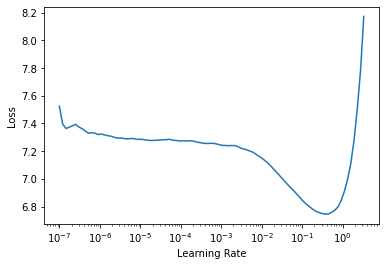

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 0.030)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.621135,5.315452,0.210412,203.456375,00:32
1,4.917043,5.185883,0.221760,178.731125,00:32


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=6.309573450380412e-07)

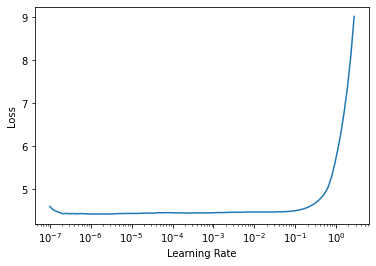

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.432629,5.185884,0.221825,178.731293,00:32
1,4.437703,5.185884,0.221719,178.731384,00:31


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=7.585775847473997e-07)

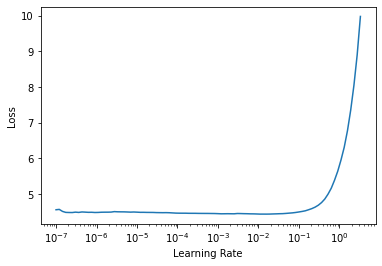

In [ ]:
learn.fit_one_cycle(2, 2e-7)
learn.lr_find()

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=2.75422871709452e-06)

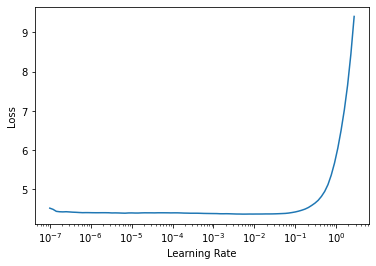

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 4e-5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.446325,5.185641,0.221931,178.687912,00:31
1,4.461283,5.184998,0.221738,178.573013,00:31
2,4.440317,5.184497,0.221909,178.483627,00:31
3,4.438278,5.184339,0.222034,178.455460,00:31
4,4.433911,5.184300,0.222096,178.448486,00:31


SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=6.309573450380412e-07)

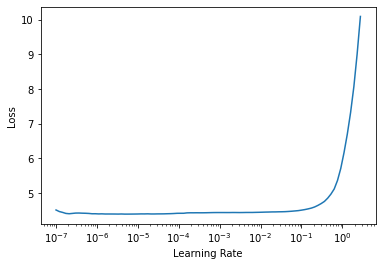

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.434700,5.184304,0.222205,178.449158,00:31
1,4.449516,5.184294,0.222056,178.447464,00:30
2,4.449416,5.184281,0.222056,178.445160,00:30
3,4.455066,5.184282,0.222142,178.445251,00:30
4,4.462187,5.184289,0.222077,178.446518,00:30


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=9.12010818865383e-07)

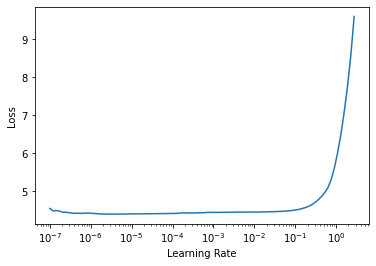

In [ ]:
learn.fit_one_cycle(5, 4e-7)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.424308,5.183963,0.222267,178.388336,00:31
1,4.432778,5.183552,0.222308,178.315109,00:31
2,4.430968,5.183478,0.222438,178.301926,00:31


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=9.12010818865383e-07)

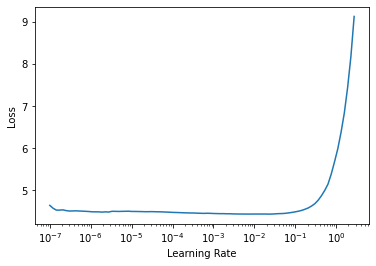

In [ ]:
learn.fit_one_cycle(3, 4e-5)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.451840,5.176722,0.222658,177.101242,00:31
1,4.401316,5.168962,0.223692,175.732422,00:31
2,4.344862,5.168524,0.223424,175.655426,00:31


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=7.585775847473997e-07)

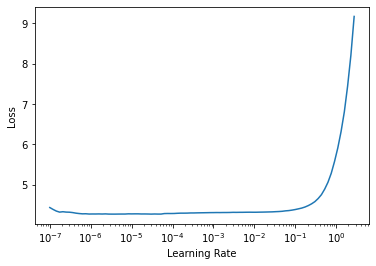

In [ ]:
learn.fit_one_cycle(3, 2e-3)
learn.lr_find()

In [ ]:

root_dir = "/content/My Drive/"
base_dir = root_dir + 'fastai-v/'

In [ ]:
dest=Path(base_dir + "onionredditfinetuneLM/")
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

File Already Exists


In [ ]:
#learn.save(dest/'11epoch')

In [ ]:
learn.save_encoder(dest/'finetuned')

In [ ]:
train

,text,labels
18421,bill clinton: sorry for the drug war,0
17424,house (anti)science panel preps 'making the epa great again' hearing,0
6593,here's what it would look like if kids planned the family vacations,0
28078,"we in golden age of thing, guy who likes thing reports",1
28021,it wasn't just white men who participated in the 'unite the right' rally,0
...,...,...
2081,changing residency standards attack student voters,0
11300,how much money do you need?,0
5096,"12-year-old says she's desperate to stop the hitting, screaming, fighting with mom",0
27780,man completely blindsided by seemingly normal stranger telling him to 'have a blessed day',1


In [ ]:
blocks = (TextBlock.from_df(0, seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock())
dls = DataBlock(blocks=blocks,
                get_x=ColReader('text'),
                get_y=ColReader('labels'),
                splitter=RandomSplitter(0.2))
dls = dls.dataloaders(train, bs=64)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos hot wheels ranked number one toy for rolling down ramp , knocking over xxunk that send xxunk down a funnel , dropping onto teeter - xxunk that yanks on string , causing xxunk system to raise wooden block , xxunk series of twine xxunk that unwind spring , launching tennis ball across room , xxunk tire down slope until it hits power switch , xxunk table fan that blows toy ship with nail attached to it across xxunk pool , popping water balloon that fills cup , weighing down lever that forces basketball down track , xxunk xxunk on axis to rotate , allowing golf ball to roll into sideways coffee mug , which xxunk down row of xxunk books until handle catches hook attached to lever that causes wooden xxunk to slam down on serving spoon , xxunk small ball into cup attached by ribbon to lazy susan",1
1,"xxbos jared kushner claims that russian interference less damaging to u.s . democracy than saudi arabia , nepotism , israel , cambridge analytica , uae , illicit donations , erik prince , bill barr , and financial xxunk",1
2,"xxbos annoying guy in movie theater constantly screaming ' get out of there , you idiot ' at bradley cooper 's character in ' a star is born '",1


In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5,
                                metrics=accuracy).to_fp16()

In [ ]:
learn = learn.load_encoder(dest/'finetuned')

In [ ]:
#finetuning the classifier
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.455645,0.385864,0.831186,00:27


SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=1.9054607491852948e-06)

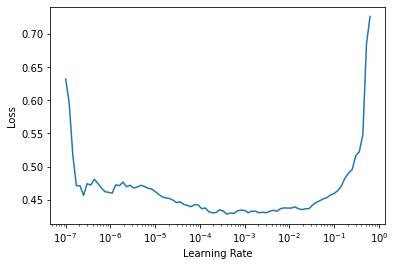

In [ ]:
learn.lr_find()

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3e-5/(2.6**4),2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.426163,0.374551,0.837519,00:28


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=7.585775847473997e-07)

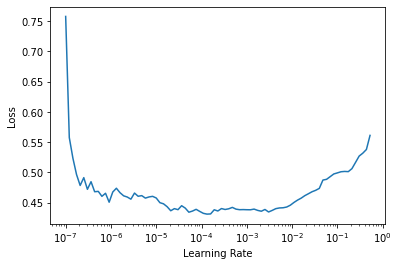

In [ ]:
learn.lr_find()

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-5/(2.6**4),1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.435298,0.376743,0.831841,00:28


SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.3182567499825382e-06)

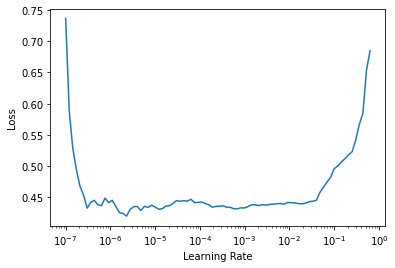

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze
learn.fit_one_cycle(2, slice(1e-7/(2.6**4),3e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.433433,0.373867,0.835990,00:28
1,0.430172,0.376262,0.834898,00:28


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=1.5848931980144698e-06)

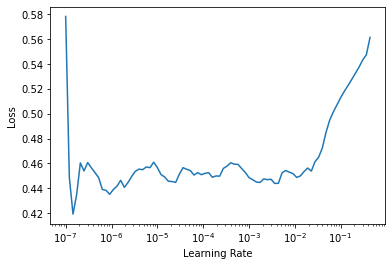

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.425601,0.373774,0.836427,00:28
1,0.428466,0.372840,0.836209,00:28
2,0.427391,0.373084,0.837301,00:28


SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=1.0964781722577754e-06)

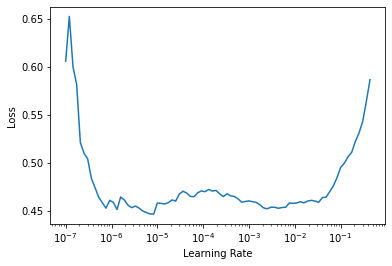

In [ ]:
learn.fit_one_cycle(3, 1e-7)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.430177,0.373702,0.836209,00:28
1,0.421986,0.371714,0.841013,00:28


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

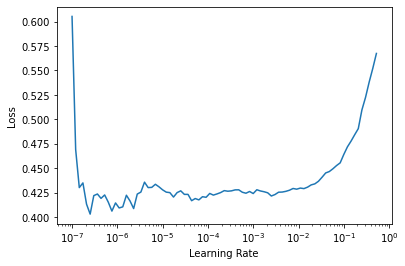

In [ ]:
learn.fit_one_cycle(2, 1e-6)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.419061,0.371282,0.839048,00:28
1,0.425250,0.373240,0.835335,00:28
2,0.421920,0.372107,0.836209,00:28


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=6.309573450380412e-07)

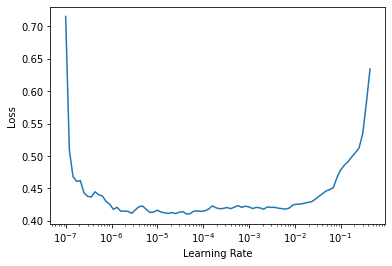

In [ ]:
learn.fit_one_cycle(3, 6e-7)
learn.lr_find()

In [ ]:
learn.recorder.plot_sched()

In [ ]:
from fastai.vision import *
val_clas = 
preds,y,losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(,preds,y,losses)

In [ ]:
interp.plot_confusion_matrix()